LAG, which returns the value at n rows before the current row. LEAD is much the same, except it returns the value at n rows AFTER the current row. These two functions are relative fetching functions, because the value they fetch is always relative to the current row. The other two fetching functions are FIRST_VALUE and LAST_VALUE. FIRST_VALUE returns the first value in the table or partition, while LAST_VALUE returns the last value in the table or partition. These two functions are absolute, because what they return isn't dependent on the current row, and is absolute with respect to the table or partition.

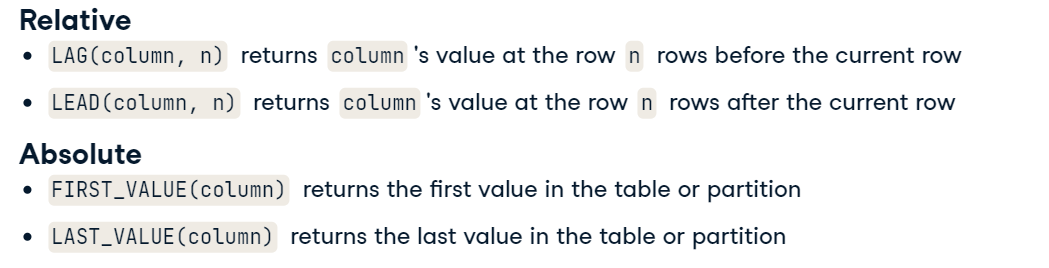

Let's start with the relative functions. 

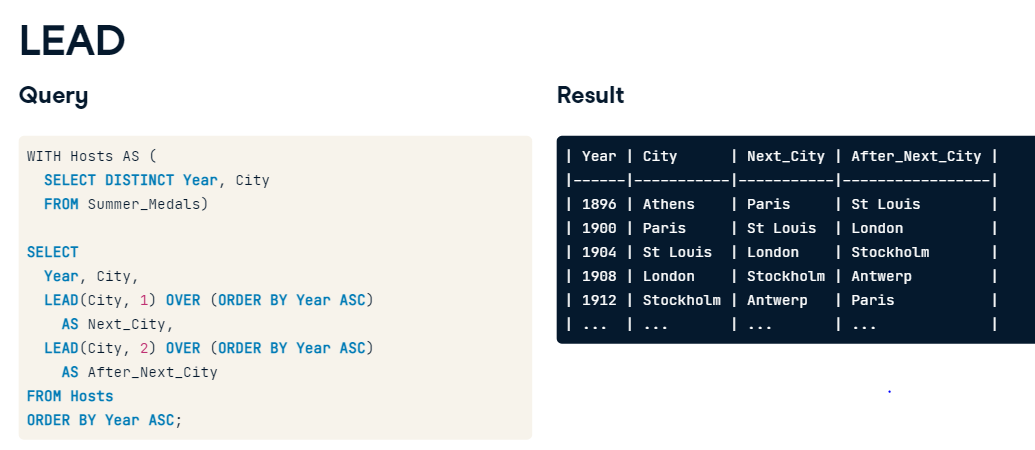

This query returns the cities in which each set of Olympic Games was held, as well as the next two cities. Passing 1 as n to LEAD will get the next city, and passing 2 as n will get the city after that. In a way similar to LAG, LEAD will return null once it runs out of following rows. In this query, the last row will have a Next_City of null, since there's no row after it to fetch its value, and the next-to-last row will have an After_Next_City of null, since LEAD-City-2 fetches the value two rows after the current row, and that row for the next-to-last row doesn't exist.

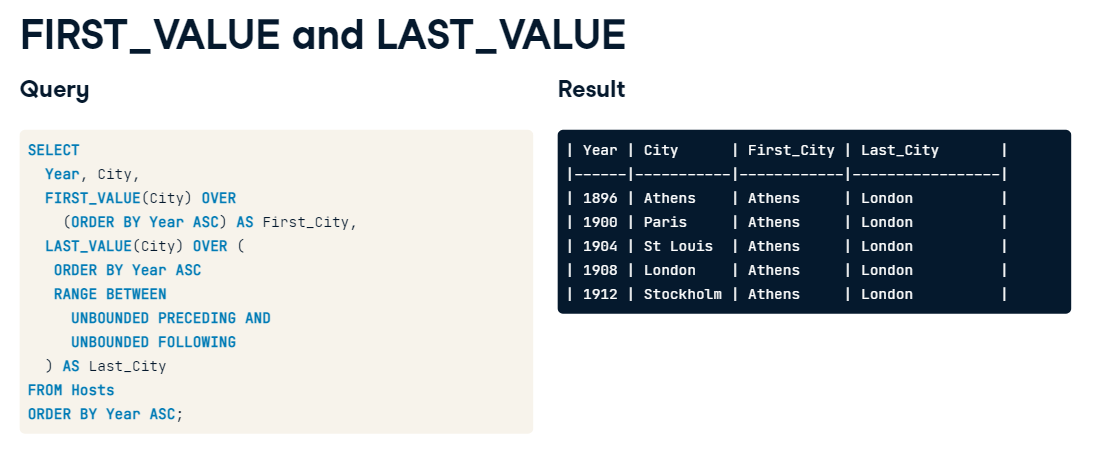

On to the absolute functions. This query is similar to the last, except it gets the first and last cities in which the Olympic Games were held in this table. The first Summer Olympic Games were held in Athens, and since 2012 is the last year that this dataset covers, London is the last city in which the games were held. FIRST_VALUE's syntax is pretty standard for window functions, but LAST_VALUE's syntax is new. Aside from the normal ORDER BY clause, there's a RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING. What does this mean? By default, a window starts at the beginning of the table or partition and ends at the current row. Without the RANGE BETWEEN clause, LAST_VALUE will get the value of the current row, so Last_City will be the same as City. The RANGE BETWEEN clause extends the window to the end of the table or partition so that the actual last value will be fetched.

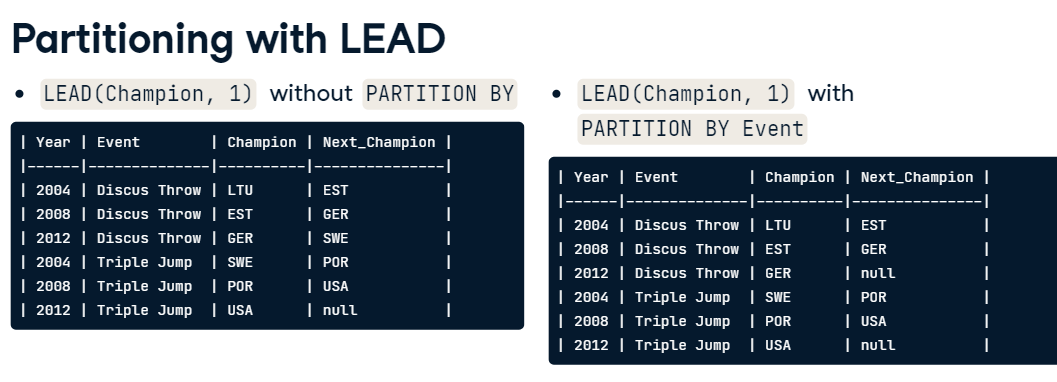

So far, you've seen the functions used over the entire table, but what happens if you want to partition? These two tables fetch the current and next champions of the Discus Throw and Triple Jump events, but the left table doesn't partition by event, while the right table does. Since the left table isn't partitioned, Discus Throw's last row will fetch Triple Jump's first champion, which isn't right. Partitioning by event will correctly set Discus Throw's last row's next champion to be null, since Discus Throw's partition ends there.

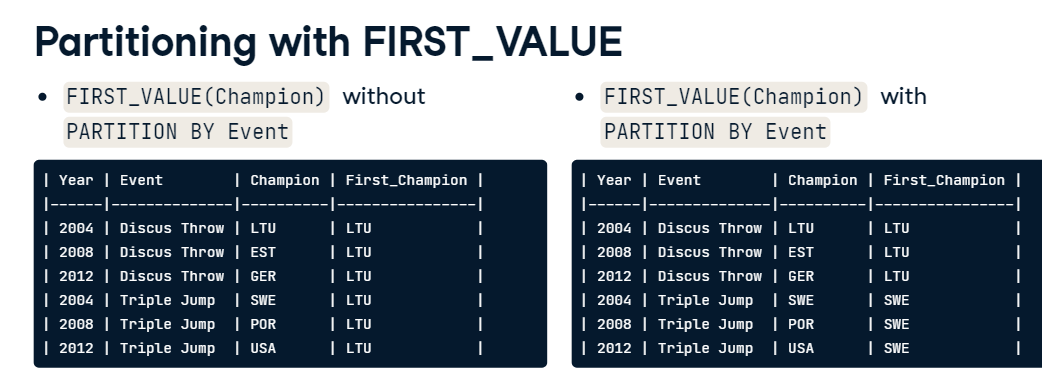

Similarly, in the left table, the table isn't partitioned by event, so LTU will be Triple Jump's First_Champion even though it's in Discus Throw. The right table IS partitioned by event, so SWE will correctly be set as Triple Jump's First_Champion. Partitioning with LAST_VALUE works much the same way.

Let's practice using the fetching functions to move values from one row to another.

#### Future gold medalists
Fetching functions allow you to get values from different parts of the table into one row. If you have time-ordered data, you can "peek into the future" with the LEAD fetching function. This is especially useful if you want to compare a current value to a future value.


- For each year, fetch the current gold medalist and the gold medalist 3 competitions ahead of the current row.


```sql
WITH Discus_Medalists AS (
  SELECT DISTINCT
    Year,
    Athlete
  FROM Summer_Medals
  WHERE Medal = 'Gold'
    AND Event = 'Discus Throw'
    AND Gender = 'Women'
    AND Year >= 2000)

SELECT
  -- For each year, fetch the current and future medalists
  Year,
  Athlete,
  LEAD(Athlete, 3) OVER (ORDER BY Year ASC) AS Future_Champion
FROM Discus_Medalists
ORDER BY Year ASC;
```

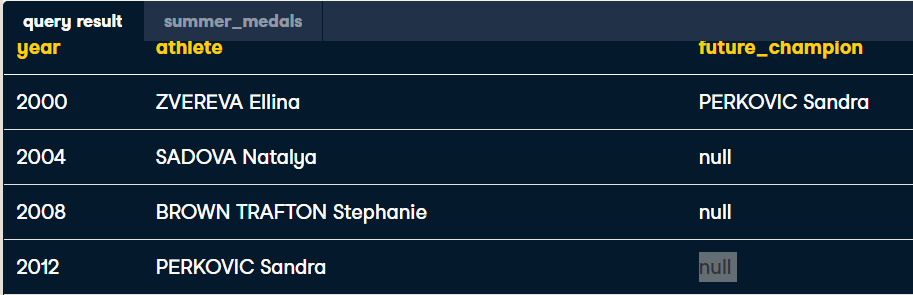


#### First athlete by name
It's often useful to get the first or last value in a dataset to compare all other values to it. With absolute fetching functions like FIRST_VALUE, you can fetch a value at an absolute position in the table, like its beginning or end.

- Return all athletes and the first athlete ordered by alphabetical order.

```sql
WITH All_Male_Medalists AS (
  SELECT DISTINCT
    Athlete
  FROM Summer_Medals
  WHERE Medal = 'Gold'
    AND Gender = 'Men')

SELECT
  -- Fetch all athletes and the first athlete alphabetically
  athlete,
  FIRST_VALUE(athlete) OVER (
    ORDER BY athlete ASC
  ) AS First_Athlete
FROM All_Male_Medalists;
```

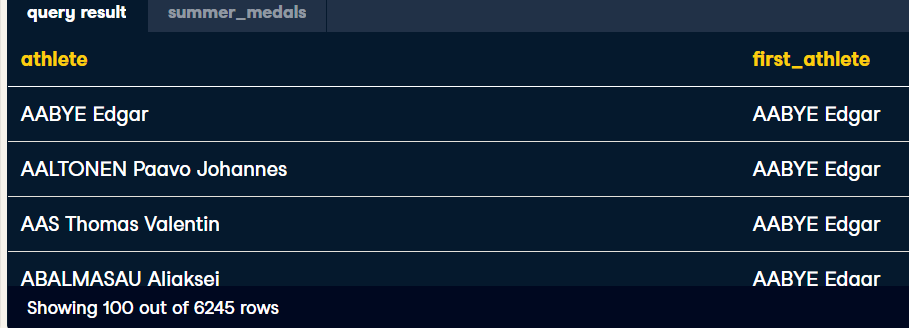

You can use absolute position fetching functions to fetch values at fixed positions in your table or partition.

#### Last country by name
Just like you can get the first row's value in a dataset, you can get the last row's value. This is often useful when you want to compare the most recent value to previous values.


- Return the year and the city in which each Olympic games were held.
- Fetch the last city in which the Olympic games were held.

```sql
WITH Hosts AS (
  SELECT DISTINCT Year, City
    FROM Summer_Medals)

SELECT
  Year,
  City,
  -- Get the last city in which the Olympic games were held
  LAST_VALUE(City) OVER (
   ORDER BY Year ASC
   RANGE BETWEEN
     UNBOUNDED PRECEDING AND
     UNBOUNDED FOLLOWING
  ) AS Last_City
FROM Hosts
ORDER BY Year ASC;
```

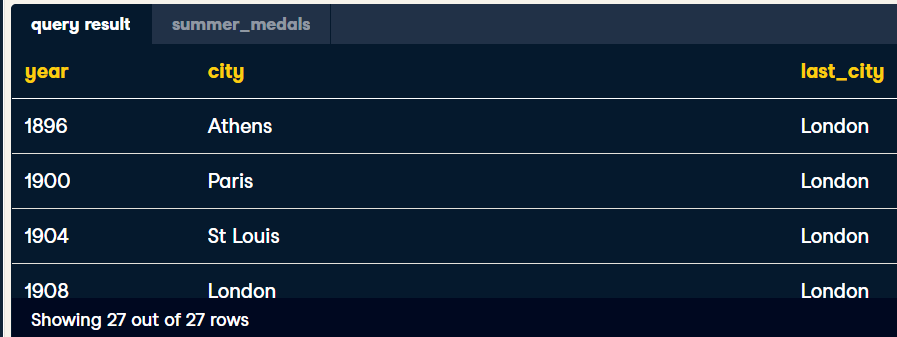

Now you can get the values of the rows at the beginning and end of your table.


Another common application of window functions is ranking rows according to their values. 

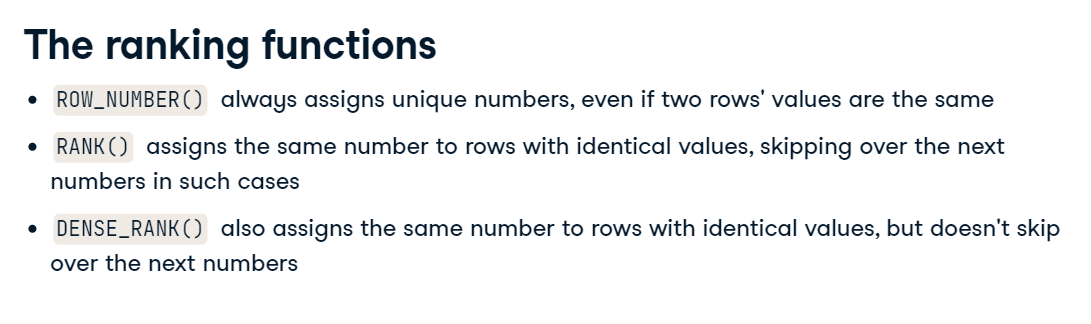

We've already encountered one ranking function last chapter: ROW_NUMBER. Assigning numbers to rows is one way of ranking them. ROW_NUMBER always assigns unique numbers, even if two rows' values are the same; it chooses some other metric to assign numbers if the value by which it's ordering is the same. Another ranking function is RANK. It assigns the same number to rows with identical values, skipping over the next numbers in such cases. Finally, DENSE_RANK also assigns the same number to rows with identical values, but doesn't skip over the next numbers. This sounds a bit abstract, so let's see all three functions used at once to distinguish between their outputs.

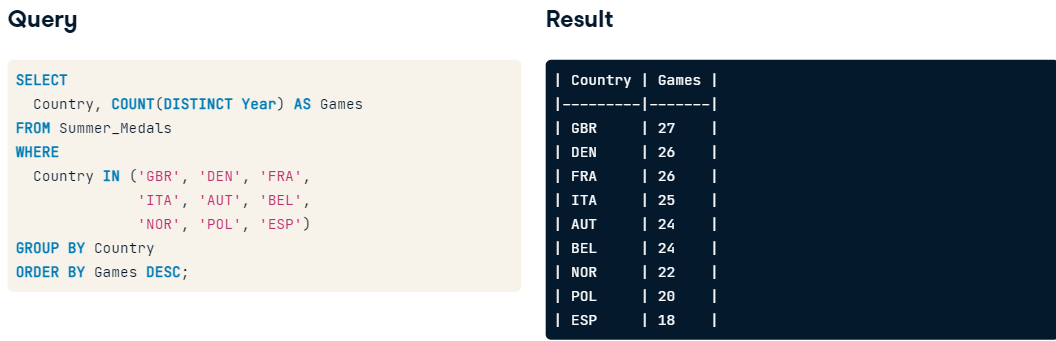

This query returns the number of Olympic games in which each of these countries has participated. Notice that some countries, such as France and Denmark, have participated in the same number of games. How would you rank them? Let's apply the three ranking functions to see how each handles these repeated values.

After wrapping the previous query in a CTE and applying the three ranking functions to them, let's see the differences in the output. ROW_NUMBER's output is familiar; it assigns a unique number to each row based on the provided order. If two rows have the same value, it still assigns them unique numbers, but based on an internally selected order.

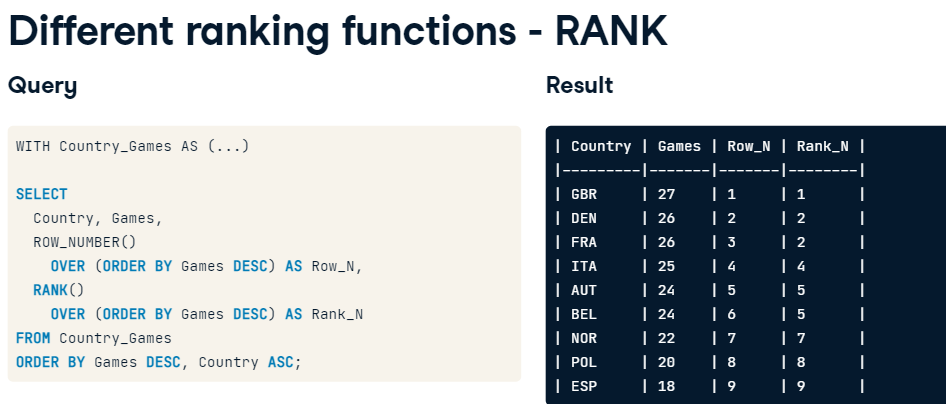

RANK will assign the same number to two rows if their values are equal; both Denmark and France are second here. 

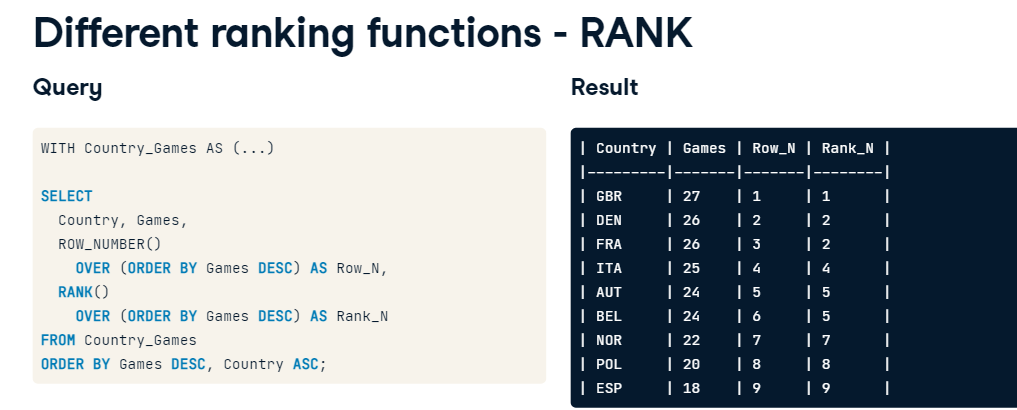

After the repeated ranks, it skips over the next rank, and immediately goes to four for Italy. RANK always skips over the next numbers if it assigns the same number to two or more rows.

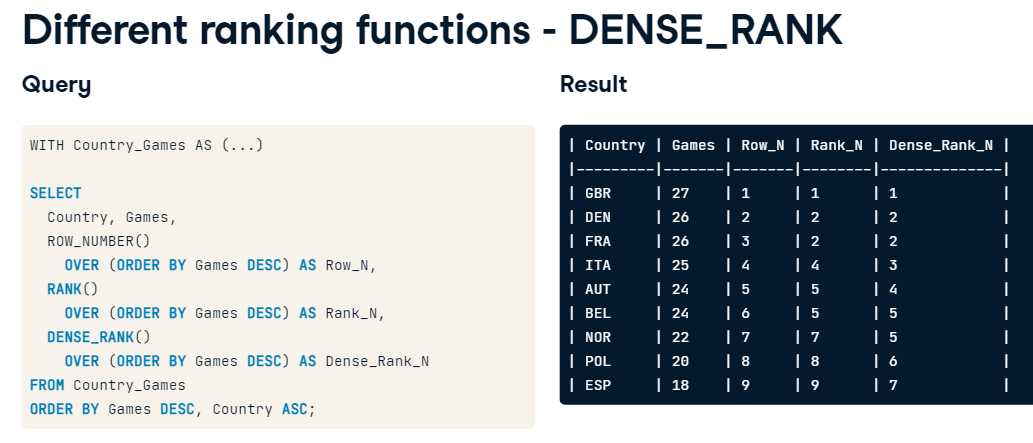

DENSE_RANK also assigns 2 to Denmark and France, but instead of skipping the next rank, it assigns 3 to Italy. DENSE_RANK never skips ranks. ROW_NUMBER and RANK will have the same last rank, the count of rows, while DENSE_RANK's last rank is the count of unique values being ranked.

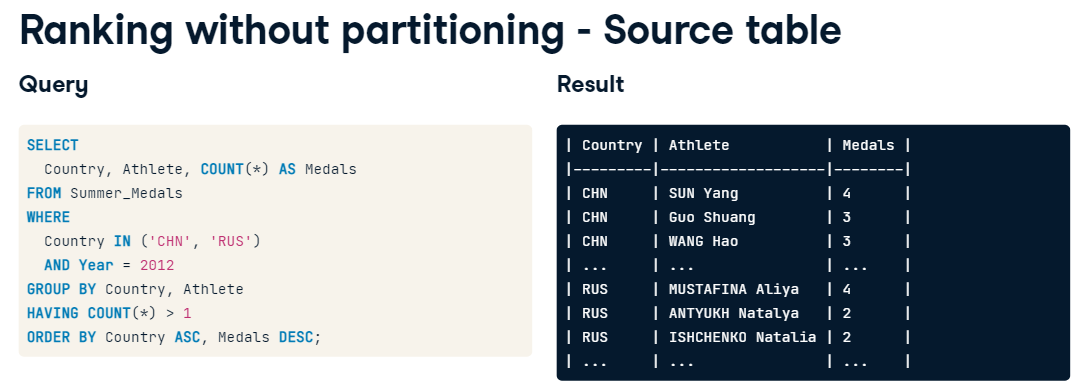

What if you have several groups you need to rank separately in your data? This query returns two groups of athletes from China and Russia that need to be ranked by how many medals they've earned. Let's see what happens when you rank them without partitioning.

The two groups of athletes are ranked here without partitioning. Because of the ORDER BY clause at the end of the query, the results are ordered correctly, but notice that the Russian athletes who won 2 medals each are ranked third, when they should be ranked second. That's because they're ranked relative to the entire table, not to the Russian group of athletes.

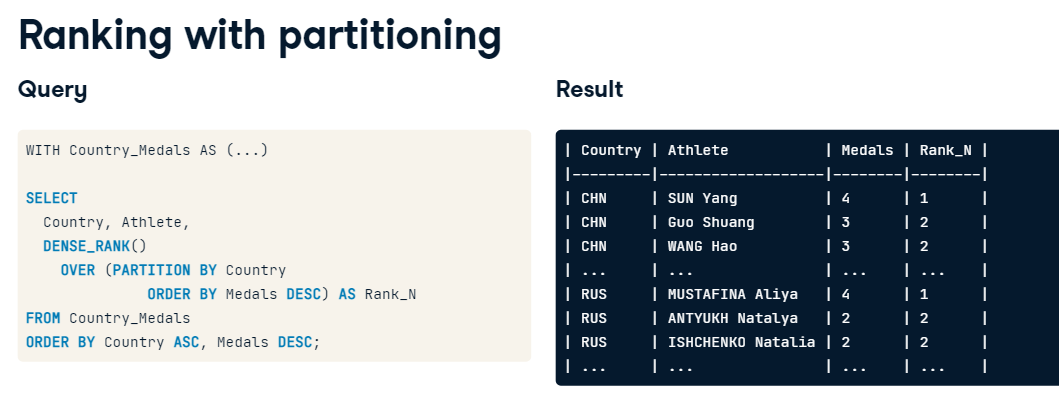

After partitioning by country, the Russian athletes are correctly assigned the second rank because they're being ranked only relative to the other athletes in their group or partition. If you have more than one group whose rows you want to rank, make sure to partition by the column that splits your rows into the correct groups.

Practice ranking rows with the different ranking functions in the following exercises.

#### Ranking athletes by medals earned
Previously, you used ROW_NUMBER to rank athletes by awarded medals. However, ROW_NUMBER assigns different numbers to athletes with the same count of awarded medals, so it's not a useful ranking function; if two athletes earned the same number of medals, they should have the same rank.


- Rank each athlete by the number of medals they've earned -- the higher the count, the higher the rank -- with identical numbers in case of identical values.


```sql
WITH Athlete_Medals AS (
  SELECT
    Athlete,
    COUNT(*) AS Medals
  FROM Summer_Medals
  GROUP BY Athlete)

SELECT
  Athlete,
  Medals,
  -- Rank athletes by the medals they've won
  RANK() OVER (ORDER BY Medals DESC) AS Rank_N
FROM Athlete_Medals
ORDER BY Medals DESC;
```

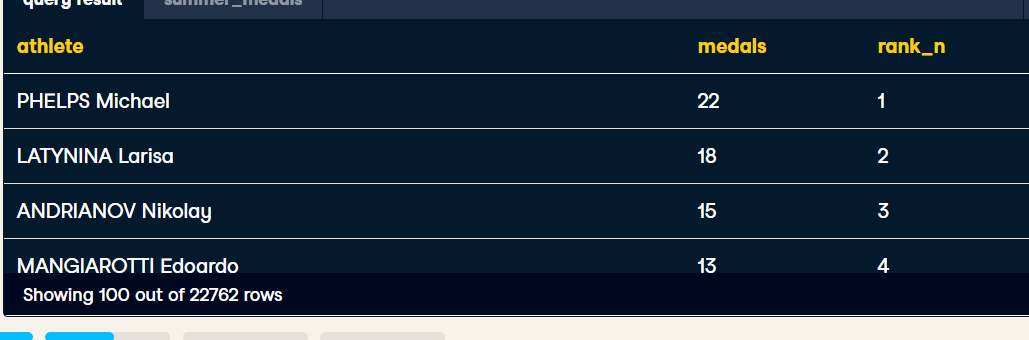

RANK's output corresponds to the actual Olympics' ranking system.

#### Ranking athletes from multiple countries
In the previous exercise, you used RANK to assign rankings to one group of athletes. In real-world data, however, you'll often find numerous groups within your data. Without partitioning your data, one group's values will influence the rankings of the others.

Also, while RANK skips numbers in case of identical values, the most natural way to assign rankings is not to skip numbers. If two countries are tied for second place, the country after them is considered to be third by most people.


- Rank each country's athletes by the count of medals they've earned -- the higher the count, the higher the rank -- without skipping numbers in case of identical values.


```sql
WITH Athlete_Medals AS (
  SELECT
    Country, Athlete, COUNT(*) AS Medals
  FROM Summer_Medals
  WHERE
    Country IN ('JPN', 'KOR')
    AND Year >= 2000
  GROUP BY Country, Athlete
  HAVING COUNT(*) > 1)

SELECT
  Country,
  -- Rank athletes in each country by the medals they've won
  Athlete,
  DENSE_RANK() OVER (PARTITION BY Country
                ORDER BY Medals DESC) AS Rank_N
FROM Athlete_Medals
ORDER BY Country ASC, RANK_N ASC;
```
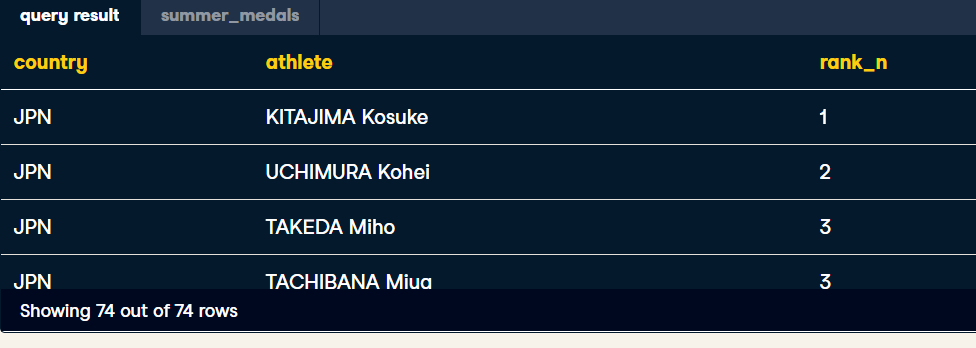

DENSE_RANK's way of ranking is how we'd typically assign ranks in real life.

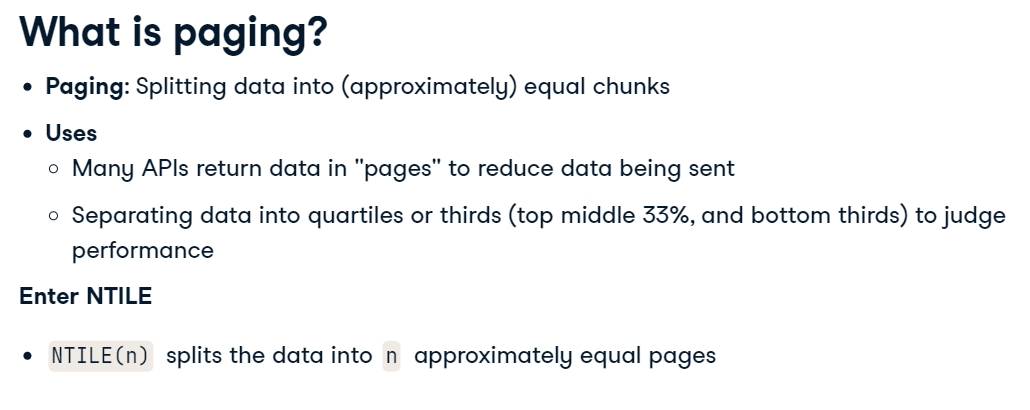


Paging is splitting data into (approximately) equal chunks. APIs are interfaces to exchange data between different web platforms, and many APIs return data in "pages" to reduce the size of the data being sent, and make it more on demand. Also, when data is sorted by a metric, separating data into quartiles or thirds can help judge performance, since one can see whether a data point is in the top, middle, or bottom third. How do you paginate data in SQL? Enter NTILE. NTILE is a window function that takes as input n, then splits the data into n approximately equal pages. Let's see NTILE in action.

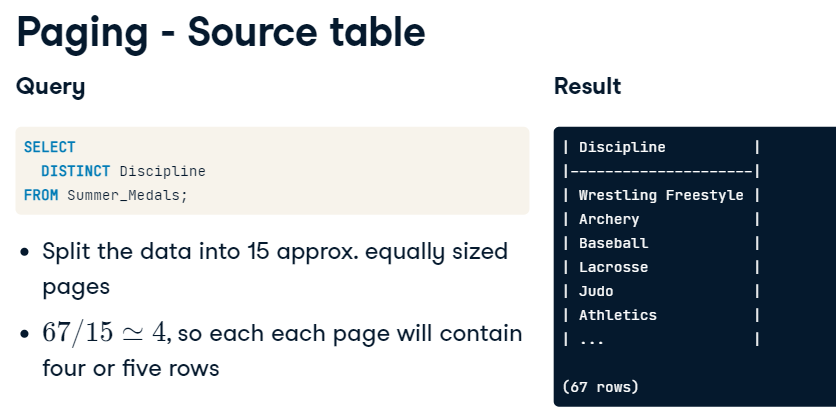

This query returns all 67 unique disciplines. Splitting them into 15 approximately equal pages will net around 4 or 5 rows in each page. The reason why the number of rows per page isn't constant is because 67 is not evenly divided by 15, so there will be overflow in some pages.

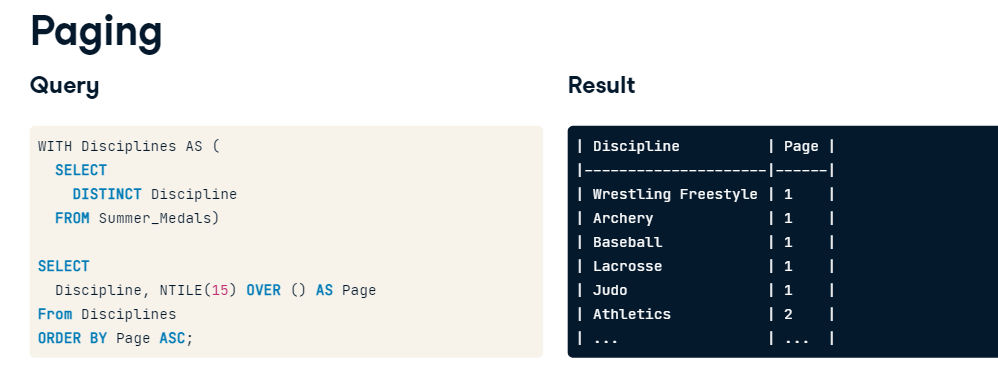

Place the previous query in a CTE, and use NTILE, passing 15 as n. In the result, the query's rows are split into 15 pages, with around four or five rows per page. For example, Page 1 has 5 rows, but Page 2 has four, though the results are truncated here for space.

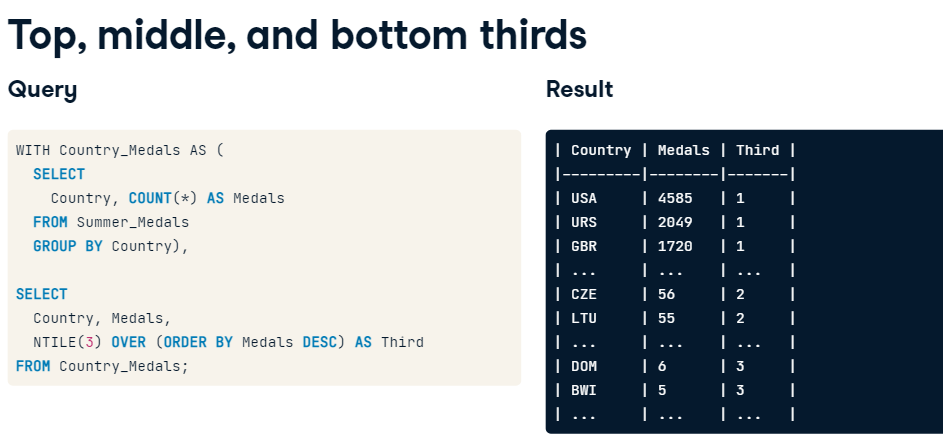

Another use for NTILE is to split the data into thirds or quartiles. Here, the Country_Medals CTE counts the number of medals each country has been awarded overall in each set of Olympic Games. Using NTILE and passing 3 as n, and ordering by the medals awarded in descending order, the query's results will be split into thirds, with the top 33% of countries by medals awarded in the top third (with the Third column's value being 1), the middle 33% in the middle third (with the Third column's value being 2), and the bottom 33% in the bottom third (with the Third column's value being 3). This way, you can easily label the top, middle, or bottom x% of your data.

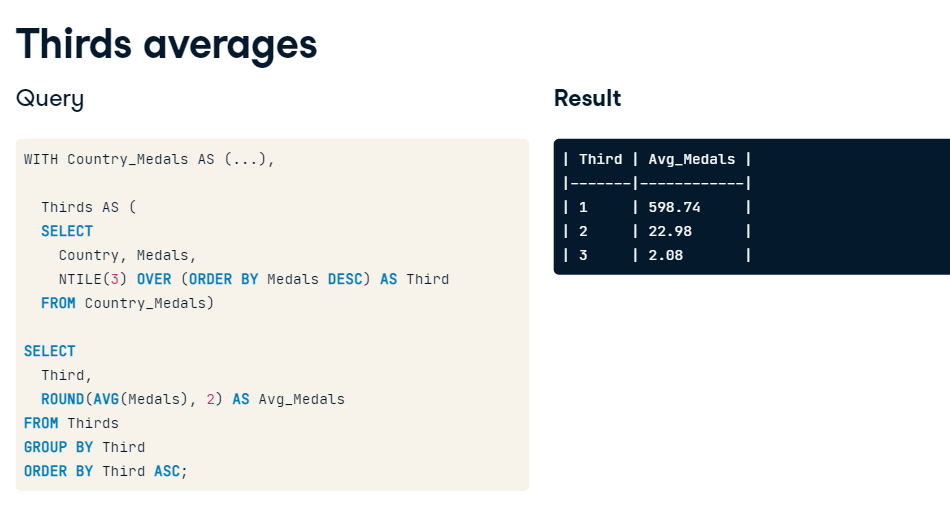

Grouping by the Third column, you can see that the top third has an average count of awarded medals of almost 600; the middle third has an average of about 23, and the bottom third has an average of 2 medals.

Now that you've seen the uses of NTILE in paging and labeling the top, middle, and bottom x% of your data, practice using it in the following exercises.


#### Paging events
There are exactly 666 unique events in the Summer Medals Olympics dataset. If you want to chunk them up to analyze them piece by piece, you'll need to split the events into groups of approximately equal size.


- Split the distinct events into exactly 111 groups, ordered by event in alphabetical order.

```sql
WITH Events AS (
  SELECT DISTINCT Event
  FROM Summer_Medals)
  
SELECT
  --- Split up the distinct events into 111 unique groups
  Event,
  NTILE(111) OVER (ORDER BY events ASC) AS Page
FROM Events
ORDER BY Event ASC;
```

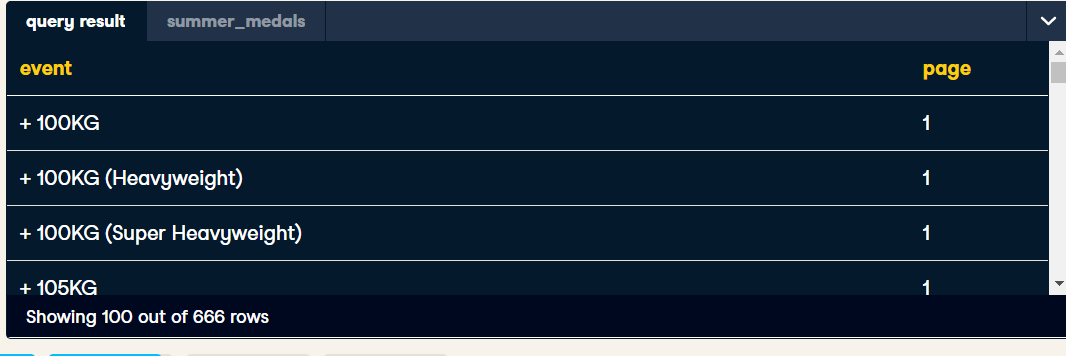

#### Top, middle, and bottom thirds
Splitting your data into thirds or quartiles is often useful to understand how the values in your dataset are spread. Getting summary statistics (averages, sums, standard deviations, etc.) of the top, middle, and bottom thirds can help you determine what distribution your values follow.


- Split the athletes into top, middle, and bottom thirds based on their count of medals.

```sql
WITH Athlete_Medals AS (
  SELECT Athlete, COUNT(*) AS Medals
  FROM Summer_Medals
  GROUP BY Athlete
  HAVING COUNT(*) > 1)
  
SELECT
  Athlete,
  Medals,
  -- Split athletes into thirds by their earned medals
  NTILE(3) OVER (ORDER BY Medals DESC) AS Third
FROM Athlete_Medals
ORDER BY Medals DESC, Athlete ASC;
```

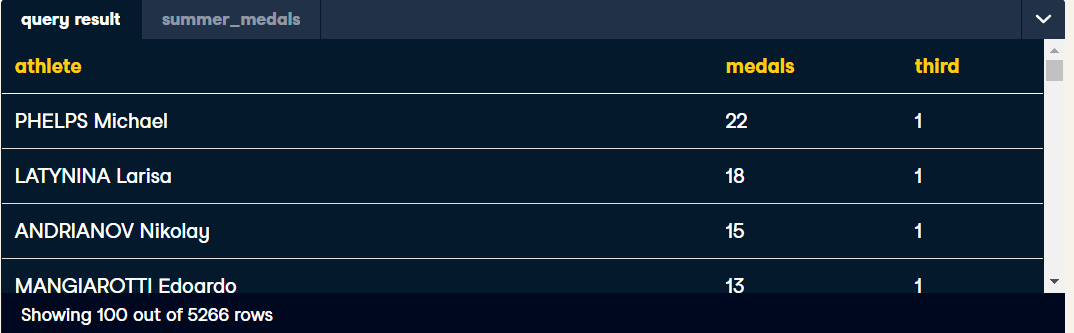

- Return the average of each third.

```sql
WITH Athlete_Medals AS (
  SELECT Athlete, COUNT(*) AS Medals
  FROM Summer_Medals
  GROUP BY Athlete
  HAVING COUNT(*) > 1),
  
  Thirds AS (
  SELECT
    Athlete,
    Medals,
    NTILE(3) OVER (ORDER BY Medals DESC) AS Third
  FROM Athlete_Medals)
  
SELECT
  -- Get the average medals earned in each third
  Third,
  AVG(medals) AS Avg_Medals
FROM Thirds
GROUP BY Third
ORDER BY Third ASC;
```
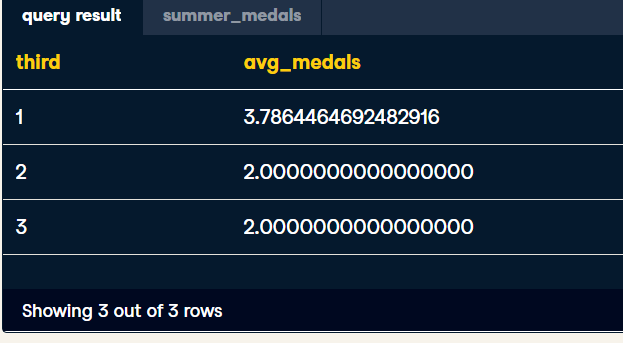

Using NTILE() and summary statistic functions, you could see the differences in the top, middle, and bottom thirds.

